In [1]:
import cv2
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split
from loguru import logger 
import rioxarray as rxr
import matplotlib

import warnings
warnings.filterwarnings("ignore")

In [2]:
path = "/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/"
images_train_path = os.path.join(path,'s2_image')
images_train = sorted(glob.glob(os.path.join(images_train_path, "**/*.tif"), recursive=True))
print("IMAGES {} ### Total:  {}".format(images_train_path, len(images_train)))
mask_train_path = os.path.join(path,'mask')
mask_train = sorted(glob.glob(os.path.join(mask_train_path, "**/*.tif"), recursive=True))
print("MASK {} ### Total:  {}".format(mask_train_path, len(mask_train)))

IMAGES /home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image ### Total:  2066
MASK /home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/mask ### Total:  2066


In [3]:
# TODO
# Generate Dataframe train/test
# Generate Dataframe valid
# Save as CSV
# Dataloader modification
# Metrics modification
# Loss modification BCE

In [4]:
df_train = pd.DataFrame(columns=['rgb_path','mask_path','dataset'])
df_train['rgb_path'] = images_train
df_train['mask_path'] = mask_train
df_train['dataset']  = 'solafune'

In [5]:
df_train.head()

,rgb_path,mask_path,dataset
0,/home/sebastien/Documents/projects/solafune-so...,/home/sebastien/Documents/projects/solafune-so...,solafune
1,/home/sebastien/Documents/projects/solafune-so...,/home/sebastien/Documents/projects/solafune-so...,solafune
2,/home/sebastien/Documents/projects/solafune-so...,/home/sebastien/Documents/projects/solafune-so...,solafune
3,/home/sebastien/Documents/projects/solafune-so...,/home/sebastien/Documents/projects/solafune-so...,solafune
4,/home/sebastien/Documents/projects/solafune-so...,/home/sebastien/Documents/projects/solafune-so...,solafune


In [6]:
df_train, df_test = train_test_split(df_train, test_size=0.30, random_state=42)
df_test, df_val = train_test_split(df_test, test_size=0.30, random_state=42)

In [7]:
print("train data: {}".format(len(df_train)))
print("test data: {}".format(len(df_test)))
print("val data: {}".format(len(df_val)))

train data: 1446
test data: 434
val data: 186


In [8]:
# train_shuffle = shuffle(df_train, random_state=42)

# test_shuffle = shuffle(df_test, random_state=42)

# valid_shuffle = shuffle(df_val, random_state=42)

In [9]:
df_train.to_csv("../data_splits/train_path.csv")
df_val.to_csv("../data_splits/valid_path.csv")
df_test.to_csv("../data_splits/test_path.csv")

# Data exploration

In [10]:
data = rxr.open_rasterio(images_train[100], masked=False)
data

<xarray.DataArray (band: 12, y: 23, x: 23)>
[6348 values with dtype=float64]
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * x            (x) float64 0.5 1.5 2.5 3.5 4.5 ... 18.5 19.5 20.5 21.5 22.5
  * y            (y) float64 0.5 1.5 2.5 3.5 4.5 ... 18.5 19.5 20.5 21.5 22.5
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [11]:
image = data.values
print(image.shape)

(12, 23, 23)


# Creating raw RGB composite

In [12]:
# RED -> Band 4 
# Green -> Band 3
# Blue -> Band 2 

red = image[3,:,:]
green = image[2,:,:]
blue = image[1,:,:]

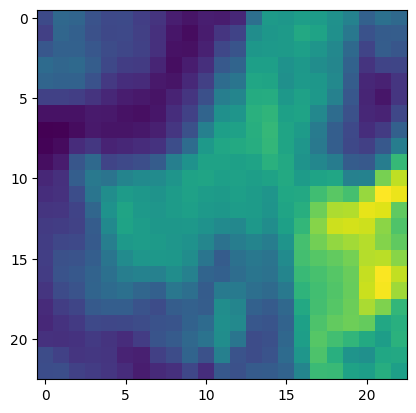

In [13]:
plt.imshow(red)

The blueish image is basically an intensity map, where each pixel represents the amount of reflected light that the Sentinel-2's sensor captured in the red band. The brighter pixels (higher values) represent more red content and the darker pixels (lower values) represent less red content.

We can change the blueish representation with the 'cmap' command. In the example below I choose 'Reds' representation.
(Note there are many other options as well. For more details please look ath the Matplotlib documentation).

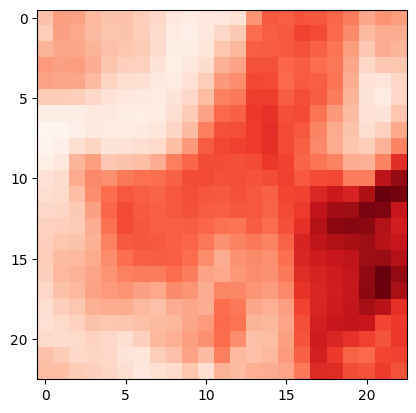

In [14]:
plt.imshow(red, cmap='Reds')

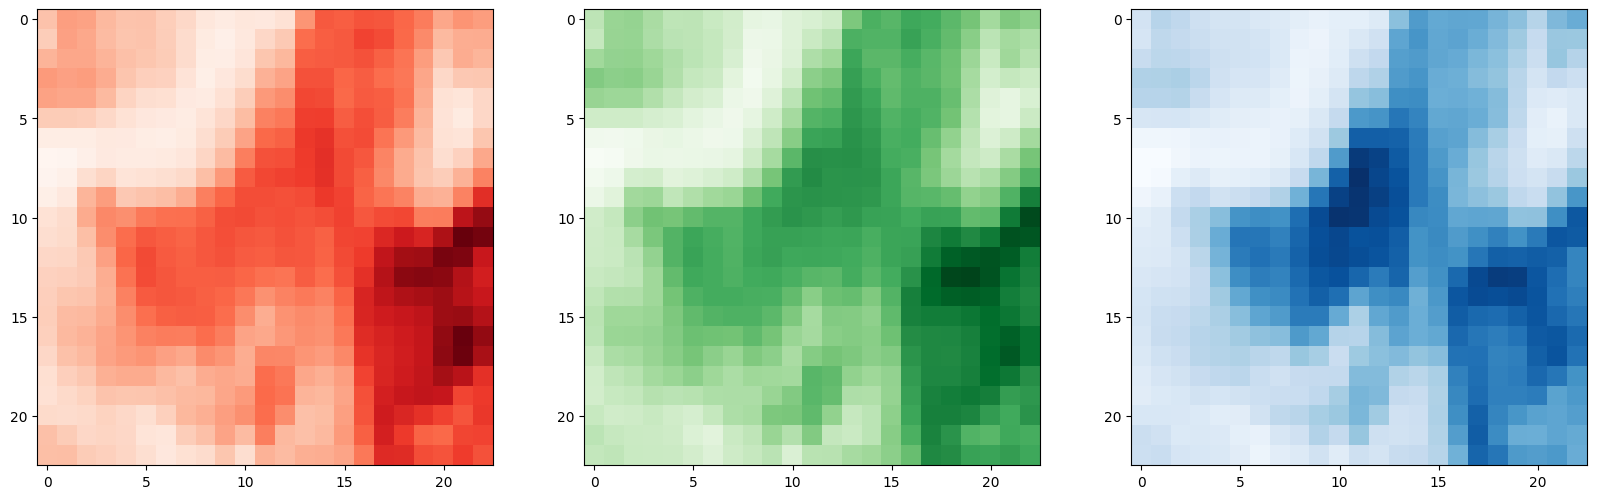

In [15]:
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(red, cmap='Reds')
ax1 = fig.add_subplot(1,3,2)
ax1.imshow(green, cmap='Greens')
ax1 = fig.add_subplot(1,3,3)
ax1.imshow(blue, cmap='Blues')

To make an RGB composite we have to stack together the Red, Green and Blue band images into one image with the np.dstack command.
If we call again the shape command on the newly created RGB composite we will see, that now we got a 3D array with the red,green and blue channels.

In [16]:
rgb_composite_raw= np.dstack((red, green, blue))
rgb_composite_raw.shape

(23, 23, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


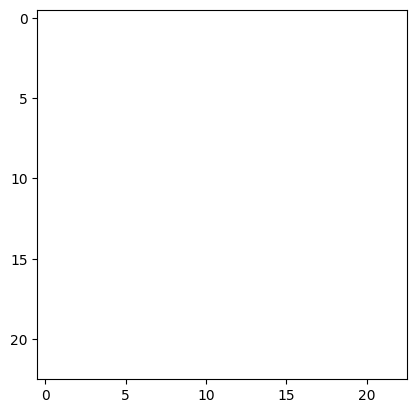

In [17]:
plt.imshow(rgb_composite_raw)

This is not quite what we are looking for, right? The root of the problem is that most images have a pixel value range from 0-255 or 0-1. If we look at the red band's max pixel value we get more than 255.

In [18]:
def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band-band_min)/((band_max - band_min)))

red_n = normalize(red)
green_n = normalize(green)
blue_n = normalize(blue)

In [19]:
red_n.max(), green_n.max(), blue_n.max()

(1.0, 1.0, 1.0)

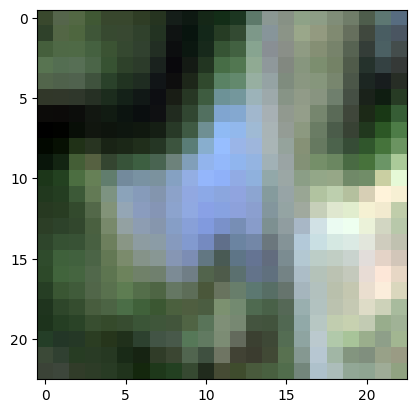

In [20]:
rgb_composite_n= np.dstack((red_n, green_n, blue_n))
plt.imshow(rgb_composite_n)

## Basic image manipulation techniques
To solve this issue, we will have to brighten each band first, then normalize them and do the stacking.
From mathematical point of view, the brightening function multiplies each pixel value with 'alpha' and adds 'beta' value if necessary.
If this operation is done we have to clip the resulted pixel values between 0..255.

In [21]:
def brighten(band):
    alpha=0.13
    beta=0
    return np.clip(alpha*band+beta, 0,255)

red_b=brighten(red)
blue_b=brighten(blue)
green_b=brighten(green)

red_bn = normalize(red_b)
green_bn = normalize(green_b)
blue_bn = normalize(blue_b)

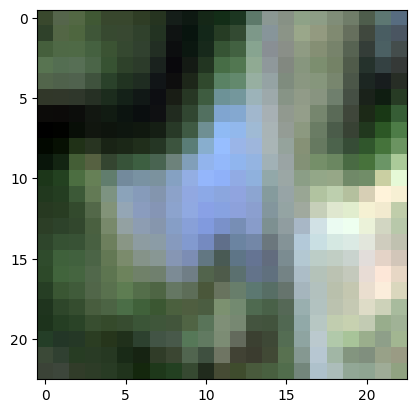

In [22]:
rgb_composite_bn= np.dstack((red_bn, green_bn, blue_bn))
plt.imshow(rgb_composite_bn)

Now our image is looking quite realistic now. Note that this image does not represent the real reflectance values.
Another image manipulation technique is gamma correction. The math behind it is that we take each pixels intesnity values and raise it to the power of (1/gamma) where the gamma value is specified by us.
Let's use our raw images, do the gamma correction and normalization.

In [23]:
def gammacorr(band):
    gamma=2
    return np.power(band, 1/gamma)

red_g=gammacorr(red)
blue_g=gammacorr(blue)
green_g=gammacorr(green)

red_gn = normalize(red_g)
green_gn = normalize(green_g)
blue_gn = normalize(blue_g)

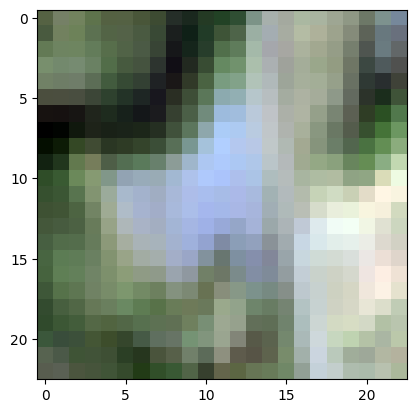

In [24]:
rgb_composite_gn= np.dstack((red_gn, green_gn, blue_gn))
plt.imshow(rgb_composite_gn)

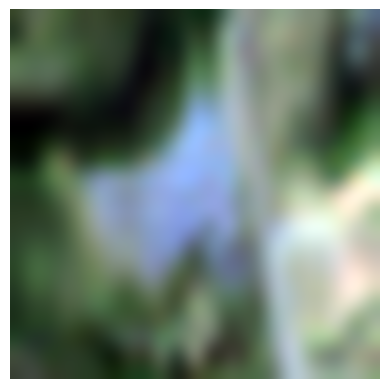

In [25]:
rgb_plot=plt.imshow(rgb_composite_bn, interpolation='lanczos')
plt.axis('off')
plt.savefig('tihany_rgb_composite.png',dpi=200,bbox_inches='tight')
plt.show()
plt.close('all')


# rgb_plot=plt.imshow(rgb_composite_bn, interpolation='lanczos')
# plt.axis('off')
# plt.savefig('tihany_rgb_composite.png',dpi=200,bbox_inches='tight')
# plt.show()
# plt.close('all')

In [26]:
def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band-band_min)/((band_max - band_min)))


def image_preprocessing(image_path):

    image = rxr.open_rasterio(image_path, masked=False).values
    red = image[3,:,:]
    green = image[2,:,:]
    blue = image[1,:,:]
    red_n = normalize(red)
    green_n = normalize(green)
    blue_n = normalize(blue)
    rgb_composite_n= np.dstack((red_n, green_n, blue_n))
    return rgb_composite_n


def visualization(df,random_choice):
    
    # random_choice = int(random.choice(np.arange(0,len(df),1)))
    # random_choice = 12

    image_path = df['rgb_path'].iloc[random_choice]
    image = rxr.open_rasterio(image_path, masked=False).values
    
    mask_path = df['mask_path'].iloc[random_choice]
    mask = rxr.open_rasterio(mask_path, masked=True).values
    mask = mask[0,:,:]
    
    red = image[3,:,:]
    green = image[2,:,:]
    blue = image[1,:,:]
    
    red_n = normalize(red)
    green_n = normalize(green)
    blue_n = normalize(blue)
    rgb_composite_n= np.dstack((red_n, green_n, blue_n))

    print("image path {}".format(image_path))
    print("image {}".format(rgb_composite_n.shape))
    print("mask path {}".format(mask_path))
    print("mask {}".format(mask.shape))
    
    
    # Create a figure with subplots to display the images
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Display the images
    axes[0].imshow(rgb_composite_n)
    axes[0].set_title('RGB Image')
    axes[0].axis('off')
    
    
    axes[1].imshow(mask)
    axes[1].set_title('Mask Image')
    axes[1].axis('off')
    
    # Show the plot
    plt.tight_layout()
    plt.show()
    

In [28]:
import torch

seg_targets = torch.load("../seg_targets")
seg_preds = torch.load("../seg_preds")

In [29]:
seg_targets.shape

seg_targets = seg_targets.detach().cpu().numpy()
seg_preds = seg_preds.detach().cpu().numpy()

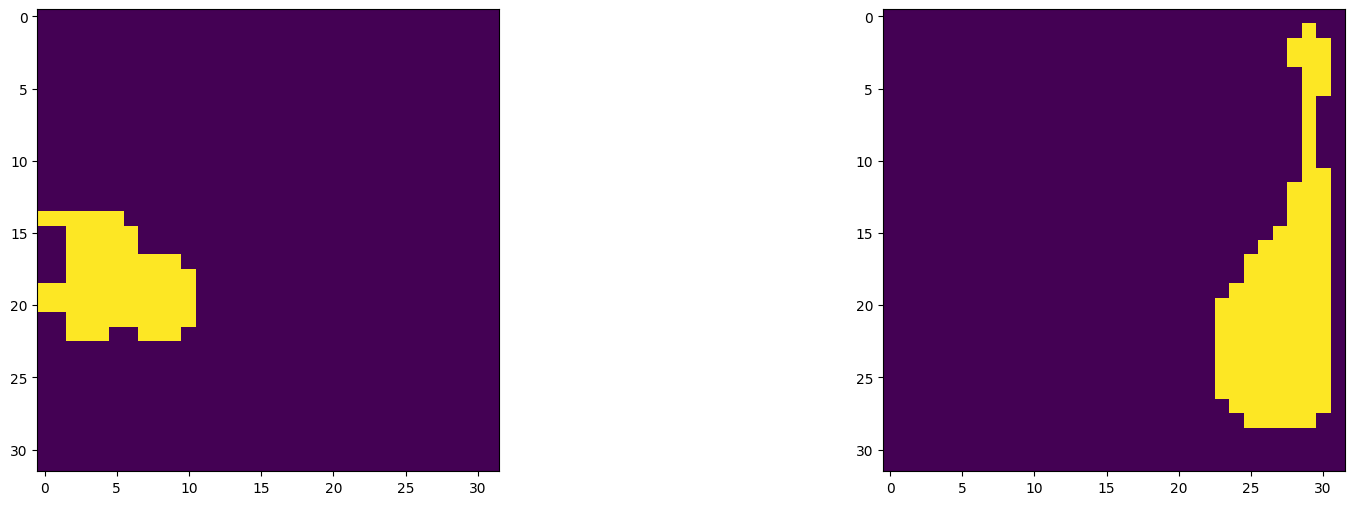

In [30]:
threshold = 0.5
binary_predictions = (seg_preds[0,0,:,:] > threshold).astype(np.uint8)
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(seg_targets[0,:,:])
ax1 = fig.add_subplot(1,2,2)
ax1.imshow(binary_predictions)

In [31]:
y_pred = binary_predictions.ravel()

In [32]:
y_true = seg_targets[0,:,:].ravel()

In [33]:
from sklearn.metrics import f1_score

In [34]:
f1_score(y_true,y_pred)

0.0

In [35]:
# TODO
# Check gtmask output of for tensorboard and compare with same gtmask output before F1-score
# change variable to gt_mask and pred_mask 
# Evaluation.py 
# Demopy to send data to Solafune